<h1 style="text-align: center; margin: 0; padding: 20px; background-color: #000; color: #fff;">Super-Marketer (User Segmentation)</h1>

# Table of Contents
- **Data Source Overview**
- **Data Preparation**
- **Data Cleaning**
- **EDA & Feature Engineering**
- **Spending Pattern User Segmentation**
- **Geographic User Segmentation**

# Data Source Overview

| Table Name     | Description                                        |
| -------------- | -------------------------------------------------- |
| `users`        | Basic user info (ID, gender, age, city, etc)       |
| `transactions` | All in-app financial transactions                  |
| `cards`        | Basic user cards info (card type, card limit, etc) |

# Data Preparation

### Import needed libraries

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, DoubleType, StringType, IntegerType, TimestampType, LongType
from pyspark.sql import functions as F

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.colors as mcolors
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection
import matplotlib.gridspec as gridspec

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

# Define custom colors
YALLA_RED = "#E10600" 
YALLA_YELLOW = "#FFD700"

### Load all datasets

In [3]:
spark = SparkSession.builder.appName("Super-Marketer").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/07/25 15:31:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
transactions_schema = StructType([
    StructField("User", IntegerType()),
    StructField("Card", IntegerType()),
    StructField("Year", IntegerType()),
    StructField("Month", IntegerType()),
    StructField("Day", IntegerType()),
    StructField("Time", StringType()),
    StructField("Amount", StringType()),
    StructField("Use Chip", StringType()),
    StructField("Merchant Name", LongType()),
    StructField("Merchant City", StringType()),
    StructField("Merchant State", StringType()),
    StructField("Zip", DoubleType()),
    StructField("MCC", IntegerType()),
    StructField("Errors?", StringType()),
    StructField("Is Fraud?", StringType())
])

cards_schema = StructType([
    StructField("User", IntegerType()),
    StructField("CARD INDEX", IntegerType()),
    StructField("Card Brand", StringType()),
    StructField("Card Type", StringType()),
    StructField("Card Number", LongType()),
    StructField("Expires", StringType()),
    StructField("CVV", IntegerType()),
    StructField("Has Chip", StringType()),
    StructField("Cards Issued", IntegerType()),
    StructField("Credit Limit", StringType()),
    StructField("Acct Open Date", StringType()),
    StructField("Year PIN last Changed", IntegerType()),
    StructField("Card on Dark Web", StringType())
])

users_schema = StructType([
    StructField("Person", StringType()),
    StructField("Current Age", IntegerType()),
    StructField("Retirement Age", IntegerType()),
    StructField("Birth Year", IntegerType()),
    StructField("Birth Month", IntegerType()),
    StructField("Gender", StringType()),
    StructField("Address", StringType()),
    StructField("Apartment", StringType()),
    StructField("City", StringType()),
    StructField("State", StringType()),
    StructField("Zipcode", IntegerType()),
    StructField("Latitude", DoubleType()),
    StructField("Longitude", DoubleType()),
    StructField("Per Capita Income - Zipcode", StringType()),
    StructField("Yearly Income - Person", StringType()),
    StructField("Total Debt", StringType()),
    StructField("FICO Score", IntegerType()),
    StructField("Num Credit Cards", IntegerType())
])

transactions = spark.read.csv("/kaggle/input/credit-card-transactions/credit_card_transactions-ibm_v2.csv",
                              header=True, schema=transactions_schema)
cards = spark.read.csv("/kaggle/input/credit-card-transactions/sd254_cards.csv", 
                       header=True, schema=cards_schema)
users = spark.read.csv("/kaggle/input/credit-card-transactions/sd254_users.csv", 
                       header=True, schema=users_schema)

In [5]:
print("Transcation record:\n", transactions.head(1))
print()
print("Card Record:\n", cards.head(1))
print()
print("User Record:\n", users.head(1))

Transcation record:
 [Row(User=0, Card=0, Year=2002, Month=9, Day=1, Time='06:21', Amount='$134.09', Use Chip='Swipe Transaction', Merchant Name=3527213246127876953, Merchant City='La Verne', Merchant State='CA', Zip=91750.0, MCC=5300, Errors?=None, Is Fraud?='No')]

Card Record:
 [Row(User=0, CARD INDEX=0, Card Brand='Visa', Card Type='Debit', Card Number=4344676511950444, Expires='12/2022', CVV=623, Has Chip='YES', Cards Issued=2, Credit Limit='$24295', Acct Open Date='09/2002', Year PIN last Changed=2008, Card on Dark Web='No')]

User Record:
 [Row(Person='Hazel Robinson', Current Age=53, Retirement Age=66, Birth Year=1966, Birth Month=11, Gender='Female', Address='462 Rose Lane', Apartment=None, City='La Verne', State='CA', Zipcode=91750, Latitude=34.15, Longitude=-117.76, Per Capita Income - Zipcode='$29278', Yearly Income - Person='$59696', Total Debt='$127613', FICO Score=787, Num Credit Cards=5)]


# Data Cleaning

In [6]:
# Remove features
cleaned_transactions = transactions.drop("Use Chip", "Merchant Name", "Merchant City", "Merchant State", "Zip")
cleaned_cards = cards.drop("Card Number", "Expires", "CVV", "Has Chip", "Cards Issued", "Credit Limit", "Card on Dark Web")
cleaned_users = users.drop("Retirement Age", "Apartment", "Per Capita Income - Zipcode")

##########################################################################################################
# Combine the timestamp of a transaction into one feature
cleaned_transactions = cleaned_transactions.withColumn("Hour", F.split(F.col("Time"), ":")[0].cast("int"))
cleaned_transactions = cleaned_transactions.withColumn("Minute", F.split(F.col("Time"), ":")[1].cast("int"))
cleaned_transactions = cleaned_transactions.withColumn(
    "timestamp",
    F.make_timestamp("Year", "Month", "Day", "Hour", "Minute", F.lit(0))
)
# Convert amount feature from string to Double
cleaned_transactions = cleaned_transactions.withColumn(
    "Amount", F.regexp_replace("Amount", "[$]", "").cast(DoubleType())
)
# Drop unuseful features
cleaned_transactions = cleaned_transactions.drop("Time", "Year", "Month", "Day", "Hour", "Minute")

cleaned_transactions = cleaned_transactions.withColumn("trans_id", F.monotonically_increasing_id())

##########################################################################################################
# Separate the open date of the card to year and month columns
cleaned_cards = cleaned_cards.withColumn("card_open_year", F.split(F.col('Acct Open Date'), "/")[0].cast("int"))
cleaned_cards = cleaned_cards.withColumn("card_open_month", F.split(F.col("Acct Open Date"), "/")[1].cast("int"))
# Drop unuseful features
cleaned_cards = cleaned_cards.drop("Acct Open Date")
cleaned_cards = cleaned_cards.withColumn("card_id", F.monotonically_increasing_id())

##########################################################################################################
cleaned_users = cleaned_users.withColumn(
    "Yearly Income - Person", F.regexp_replace("Yearly Income - Person", "[$]", "").cast(DoubleType())
)
cleaned_users = cleaned_users.withColumn(
    "Total Debt", F.regexp_replace("Total Debt", "[$]", "").cast(DoubleType())
)
cleaned_users = cleaned_users.withColumn("user_id", F.monotonically_increasing_id())
cols = cleaned_users.columns
cols = ["user_id"] + [col for col in cols if col != "user_id"]
cleaned_users = cleaned_users.select(cols)

##########################################################################################################
# Use standard naming convension for features
cleaned_transactions = cleaned_transactions \
.withColumnRenamed("User", "user_id") \
.withColumnRenamed("Card", "card_index") \
.withColumnRenamed("timestamp", "trans_timestamp") \
.withColumnRenamed("Amount", "trans_amount") \
.withColumnRenamed("MCC", "trans_service") \
.withColumnRenamed("Errors?", "trans_errors") \
.withColumnRenamed("IS Fraud?", "trans_is_fraud")

cleaned_cards = cleaned_cards \
.withColumnRenamed("User", "user_id") \
.withColumnRenamed("CARD INDEX", "card_index") \
.withColumnRenamed("Card Brand", "trans_card_brand") \
.withColumnRenamed("Card Type", "trans_card_type") \
.withColumnRenamed("Year PIN last Changed", "card_year_pin_last_changed")

cleaned_users = cleaned_users \
.withColumnRenamed("Person", "user_name") \
.withColumnRenamed("Current Age", "user_age") \
.withColumnRenamed("Birth Year", "user_birth_year") \
.withColumnRenamed("Birth Month", "user_birth_month") \
.withColumnRenamed("Gender", "user_gender") \
.withColumnRenamed("Address", "user_address") \
.withColumnRenamed("City", "user_city") \
.withColumnRenamed("State", "user_state") \
.withColumnRenamed("Zipcode", "user_zipcode") \
.withColumnRenamed("Latitude", "user_latitude") \
.withColumnRenamed("Longitude", "user_longitude") \
.withColumnRenamed("Yearly Income - Person", "user_yearly_income") \
.withColumnRenamed("Total Debt", "user_total_debt") \
.withColumnRenamed("Num Credit Cards", "user_num_credit_cards") \
.withColumnRenamed("FICO Score", "user_fico_score")

# EDA & Feature Engineering

### Data joining

In [7]:
# Join the data
data = cleaned_transactions \
.join(cleaned_cards, on=["card_index", "user_id"], how="left") \
.join(cleaned_users, on="user_id", how="left")

data.printSchema()

root
 |-- user_id: integer (nullable = true)
 |-- card_index: integer (nullable = true)
 |-- trans_amount: double (nullable = true)
 |-- trans_service: integer (nullable = true)
 |-- trans_errors: string (nullable = true)
 |-- trans_is_fraud: string (nullable = true)
 |-- trans_timestamp: timestamp (nullable = true)
 |-- trans_id: long (nullable = false)
 |-- trans_card_brand: string (nullable = true)
 |-- trans_card_type: string (nullable = true)
 |-- card_year_pin_last_changed: integer (nullable = true)
 |-- card_open_year: integer (nullable = true)
 |-- card_open_month: integer (nullable = true)
 |-- card_id: long (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_age: integer (nullable = true)
 |-- user_birth_year: integer (nullable = true)
 |-- user_birth_month: integer (nullable = true)
 |-- user_gender: string (nullable = true)
 |-- user_address: string (nullable = true)
 |-- user_city: string (nullable = true)
 |-- user_state: string (nullable = true)
 |-- use

In [8]:
selected_columns = ["trans_id", "user_id", "card_id", "trans_timestamp", "trans_amount", "trans_service"]
data.select(*selected_columns).write.option("header", "true").csv("trans_fact")


In [9]:
# Calculate the null values in each feature in the data
null_counts = data.select([
    F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c)
    for c in data.columns
])

# Convert to row of dictionary
null_counts_dict = null_counts.first().asDict()

# Convert to Pandas DataFrame
null_df = pd.DataFrame(
    list(null_counts_dict.items()), 
    columns=["feature", "null_count"]
)
null_df

25/07/25 15:32:37 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


,feature,null_count
0,user_id,0
1,card_index,0
2,trans_amount,0
3,trans_service,0
4,trans_errors,23998469
5,trans_is_fraud,0
6,trans_timestamp,0
7,trans_id,0
8,trans_card_brand,0
9,trans_card_type,0


### Engineer RFM Features

In [10]:
max_date = data.agg(F.max("trans_timestamp")).first()[0]

rfm = data.groupBy("user_id").agg(
    F.max("trans_timestamp").alias("last_trans_date"),
    F.count("trans_amount").alias("frequency"),
    F.sum("trans_amount").alias("monetary")
)

rfm = rfm.withColumn(
    "recency", F.datediff(F.lit(max_date), F.col("last_trans_date"))
)

rfm_df = rfm.toPandas()

rfm_df['frequency_score'] = pd.qcut(rfm_df['frequency'], 5, labels=[1, 2, 3, 4, 5])
rfm_df['monetary_score'] = pd.qcut(rfm_df['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm_df['recency_score'] = rfm_df['recency'].apply(lambda x: 1 if x > 30 else 5) # Only two values because their repeated values

### RFM Analysis

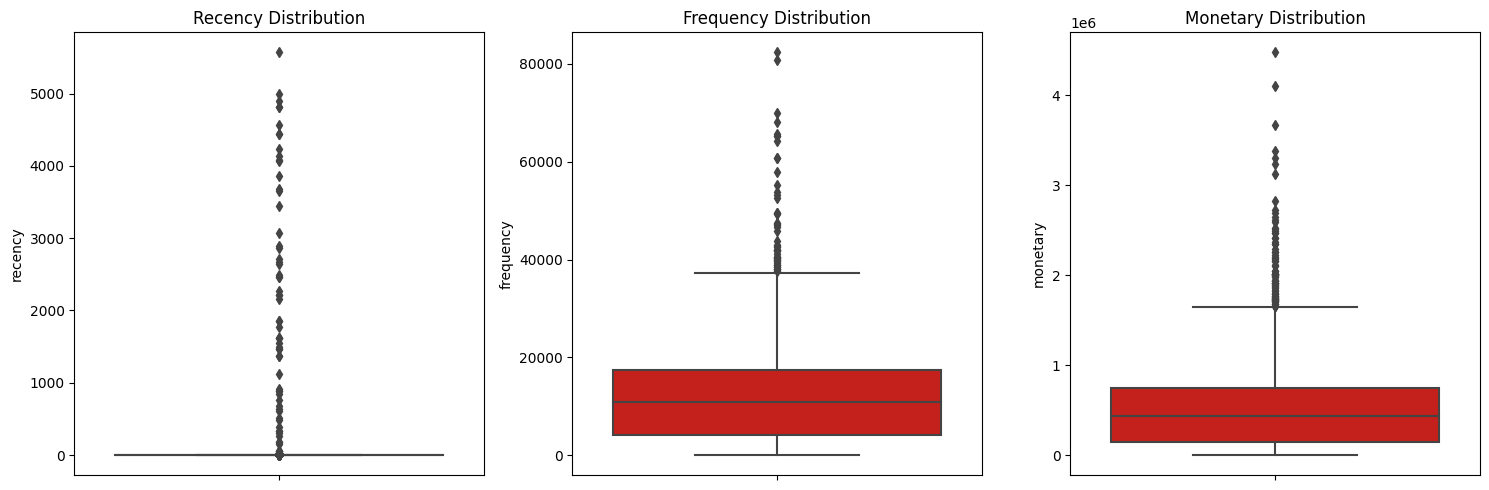

In [11]:
features = ['recency', 'frequency', 'monetary']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

for i, feature in enumerate(features):
    sns.boxplot(data=rfm_df, y=feature, ax=axes[i], color=YALLA_RED)
    axes[i].set_title(f'{feature.capitalize()} Distribution')
    axes[i].set_xlabel('')  # Optional: hide x-axis label

plt.tight_layout()
plt.show()

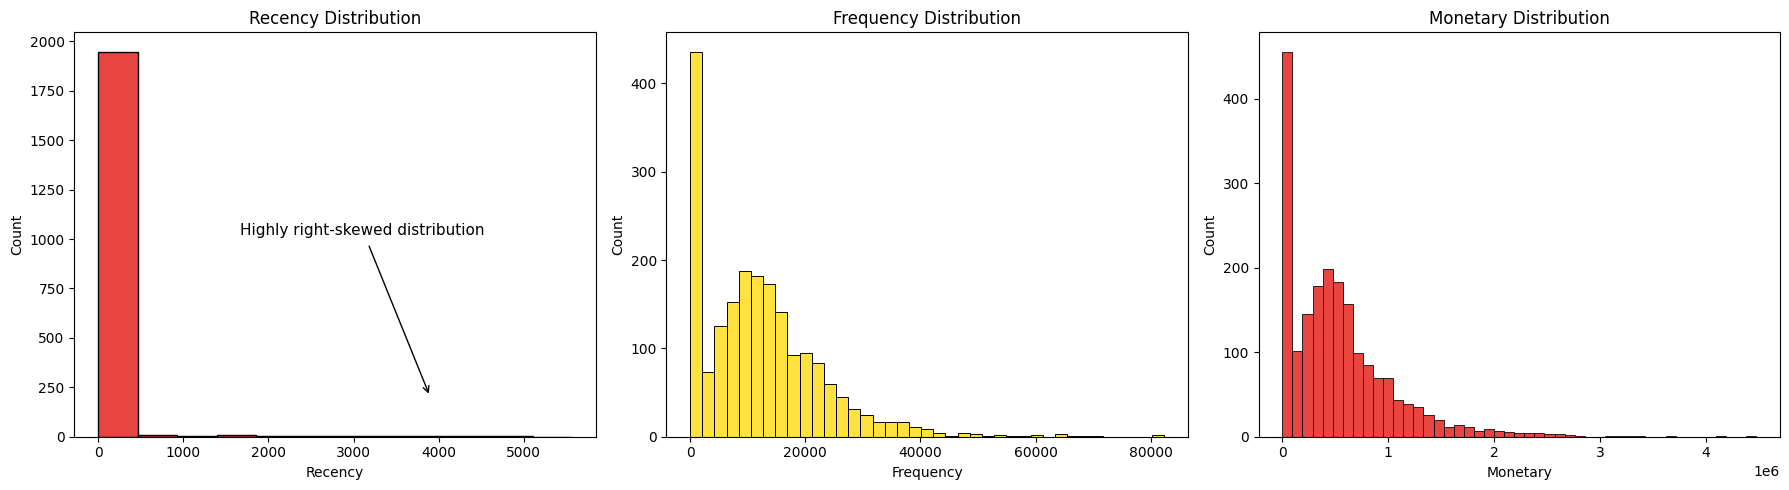

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- Recency Histogram with annotation ---
sns.histplot(rfm_df, x="recency", color=YALLA_RED, ax=axes[0])
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Recency")
axes[0].set_ylabel("Count")

# Add annotation for skewness
axes[0].annotate(
    "Highly right-skewed distribution",
    xy=(rfm_df["recency"].max() * 0.7, axes[0].get_ylim()[1] * 0.1),
    xytext=(rfm_df["recency"].max() * 0.3, axes[0].get_ylim()[1] * 0.5),
    arrowprops=dict(arrowstyle="->", color="black"),
    fontsize=11,
    backgroundcolor="white"
)

# --- Frequency Histogram ---
sns.histplot(rfm_df, x="frequency", color=YALLA_YELLOW, ax=axes[1])
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Frequency")
axes[1].set_ylabel("Count")

# --- Monetary Histogram ---
sns.histplot(rfm_df, x="monetary", color=YALLA_RED, ax=axes[2])
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Monetary")
axes[2].set_ylabel("Count")

# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
rfm_df[["recency"]].value_counts(sort=False).head(50)

recency
0          1734
1           144
2            29
3             6
4             2
10            1
28           20
29            1
59            3
151           1
181           1
182           1
265           1
303           1
334           2
393           1
485           1
516           1
610           1
631           1
671           1
758           1
842           1
881           2
911           1
1123          1
1368          2
1461          2
1489          1
1551          1
1612          3
1765          1
1854          2
2160          1
2210          1
2219          1
2271          1
2464          2
2495          1
2646          1
2676          1
2707          1
2860          1
2890          1
3073          1
3439          1
3652          1
3681          1
3864          1
4068          1
Name: count, dtype: int64

**The distribution of user recency is highly right-skewed, with the vast majority of users being very recent**.

## Spending Pattern User Segmentation

### Rule-Based Approach

In [14]:
def rule_based_clustering(row):
    high_score = [4, 5]
    medium_score = [3]
    low_score = [1, 2]

    r, f, m = row.recency_score, row.frequency_score, row.monetary_score

    # High Recency (active users)
    if r in high_score and f in high_score and m in high_score:
        return "Champions"
    elif r in high_score and f in high_score and m in medium_score:
        return "Loyal Big Spenders"
    elif r in high_score and f in high_score and m in low_score:
        return "Loyal Small Spenders"
    elif r in high_score and f in medium_score and m in high_score:
        return "Recent Big Spenders"
    elif r in high_score and f in medium_score and m in medium_score:
        return "Recent Medium Spenders"
    elif r in high_score and f in medium_score and m in low_score:
        return "Recent Low Spenders"
    elif r in high_score and f in low_score and m in high_score:
        return "New Big Spenders"
    elif r in high_score and f in low_score and m in medium_score:
        return "New Medium Spenders"
    elif r in high_score and f in low_score and m in low_score:
        return "New Low Spenders"

    # Medium Recency (moderately engaged)
    elif r in medium_score and f in high_score and m in high_score:
        return "Frequent Big Spenders"
    elif r in medium_score and f in high_score and m in medium_score:
        return "Frequent Medium Spenders"
    elif r in medium_score and f in high_score and m in low_score:
        return "Frequent Small Spenders"
    elif r in medium_score and f in medium_score and m in high_score:
        return "Engaged Big Spenders"
    elif r in medium_score and f in medium_score and m in medium_score:
        return "Engaged Medium Spenders"
    elif r in medium_score and f in medium_score and m in low_score:
        return "Engaged Low Spenders"
    elif r in medium_score and f in low_score and m in high_score:
        return "Irregular Big Spenders"
    elif r in medium_score and f in low_score and m in medium_score:
        return "Irregular Medium Spenders"
    elif r in medium_score and f in low_score and m in low_score:
        return "Irregular Low Spenders"

    # Low Recency (inactive or at-risk)
    elif (r in low_score) and (f in high_score + medium_score) or (m in high_score + medium_score):
        return "Lost: High Value Users"
    elif r in low_score and f in low_score and m in low_score:
        return "Lost: Low Value Users"
    else:
        return "Uncategorized"

rfm_df['rule_based_cluster'] = rfm_df.apply(lambda x: rule_based_clustering(x), axis=1)

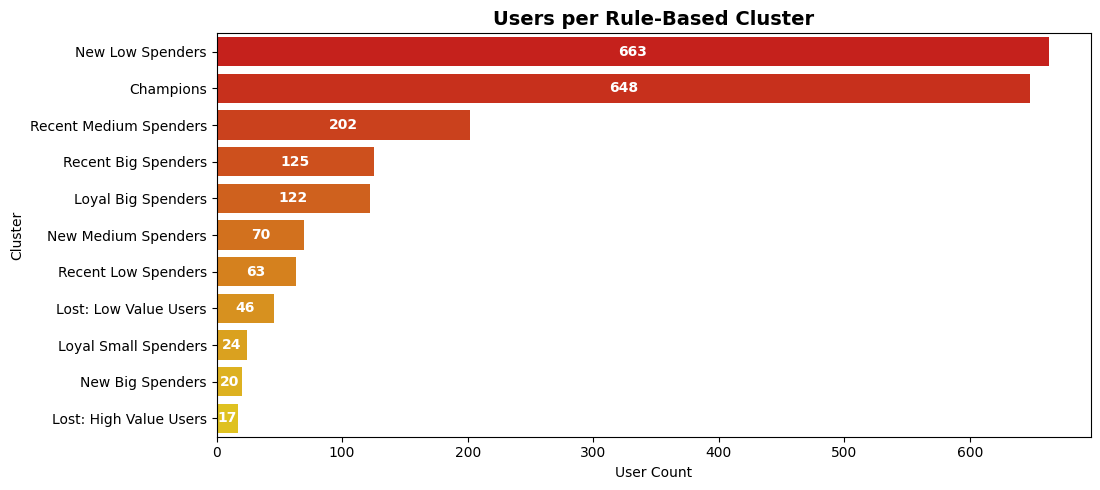

In [15]:
# Prepare data
cluster_counts = rfm_df['rule_based_cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'User Count']
cluster_counts = cluster_counts.sort_values(by='User Count', ascending=False)

# Color palette (based on number of clusters)
num_bars = len(cluster_counts)
cmap = mcolors.LinearSegmentedColormap.from_list("red_yellow", [YALLA_RED, YALLA_YELLOW])
gradient_colors = [cmap(i / (num_bars - 1)) for i in range(num_bars)]

# Set up figure and GridSpec
fig = plt.figure(figsize=(20, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# Bar Plot at position [0, 1]
ax2 = fig.add_subplot(gs[0, 1])

sns.barplot(
    data=cluster_counts,
    y='Cluster',
    x='User Count',
    palette=gradient_colors,
    ax=ax2
)

ax2.set_title("Users per Rule-Based Cluster", fontsize=14, weight='bold')
ax2.set_xlabel("User Count")
ax2.set_ylabel("Cluster")

# Add text labels
for i, val in enumerate(cluster_counts["User Count"]):
    ax2.text(
        val / 2,
        i,
        str(val),
        ha='center', va='center',
        color='white', fontsize=10, weight='bold'
    )

plt.tight_layout()
plt.show()

### K-Means Model

In [16]:
# Selected features
features = ['frequency', 'monetary', 'recency']

# Scale the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(rfm_df[features])

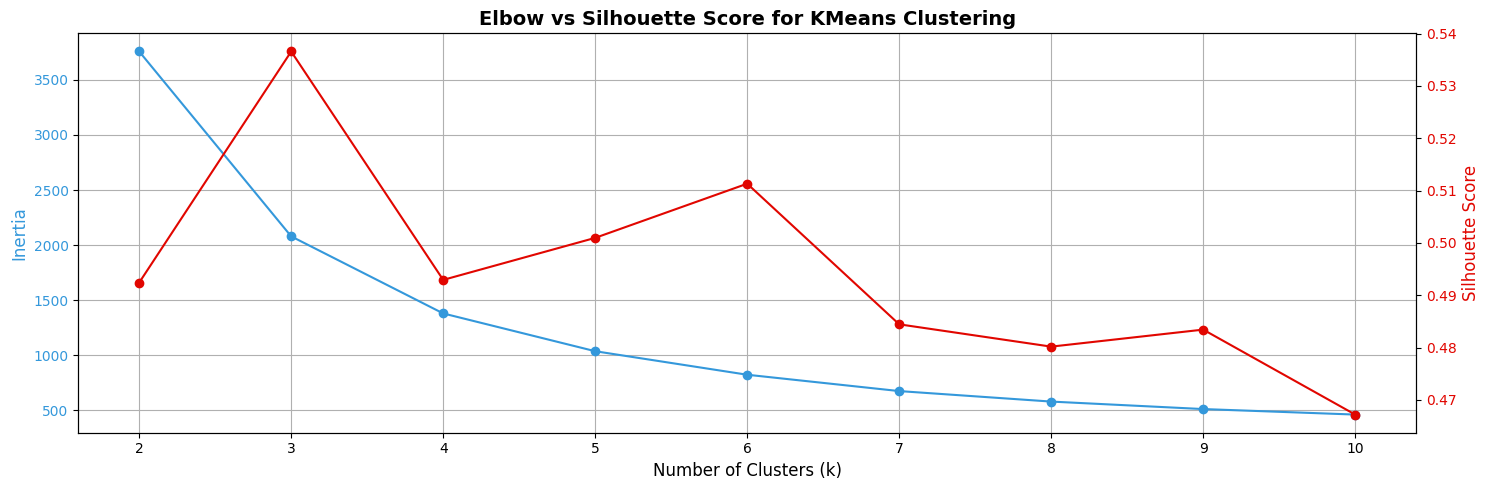

In [17]:
# K ranges
K_range = range(2, 11)

# Store metrics
inertias = []
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(scaled_features)
    
    # Append metrics
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(scaled_features, km.labels_))

# Plot
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot Inertia
ax1.plot(K_range, inertias, marker='o', color="#3498DB", label='Inertia')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Inertia', color="#3498DB", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#3498DB")

# Second y-axis for silhouette score
ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, marker='o', color=YALLA_RED, label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color=YALLA_RED, fontsize=12)
ax2.tick_params(axis='y', labelcolor=YALLA_RED)

# Title and grid
plt.title('Elbow vs Silhouette Score for KMeans Clustering', fontsize=14, weight='bold')
ax1.grid(True)

# Show
plt.tight_layout()
plt.show()

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
kmeans.fit(scaled_features)
rfm_df['k_means_cluster'] = kmeans.labels_

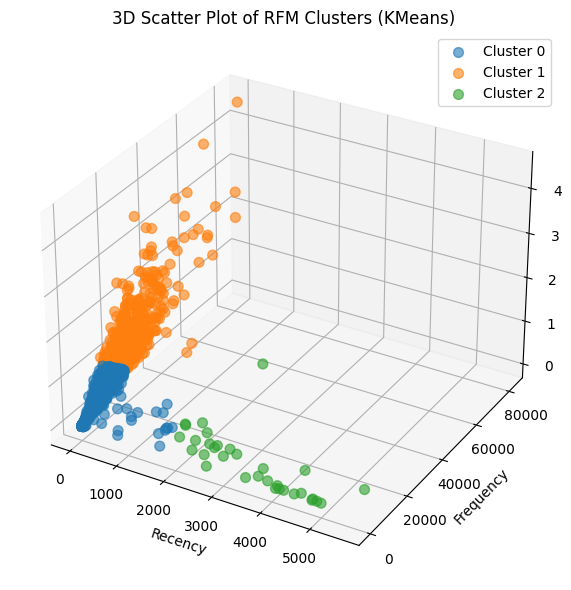

In [19]:
# Add cluster labels
rfm_df['k_means_cluster'] = kmeans.labels_

# Prepare 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster separately
for cluster_id in sorted(rfm_df['k_means_cluster'].unique()):
    cluster_data = rfm_df[rfm_df['k_means_cluster'] == cluster_id]
    ax.scatter(
        cluster_data['recency'],
        cluster_data['frequency'],
        cluster_data['monetary'],
        label=f'Cluster {cluster_id}',
        s=50,  # size of points
        alpha=0.6
    )

# Set labels and title
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters (KMeans)')
ax.legend()
plt.tight_layout()
plt.show()

### DBSCAN Model

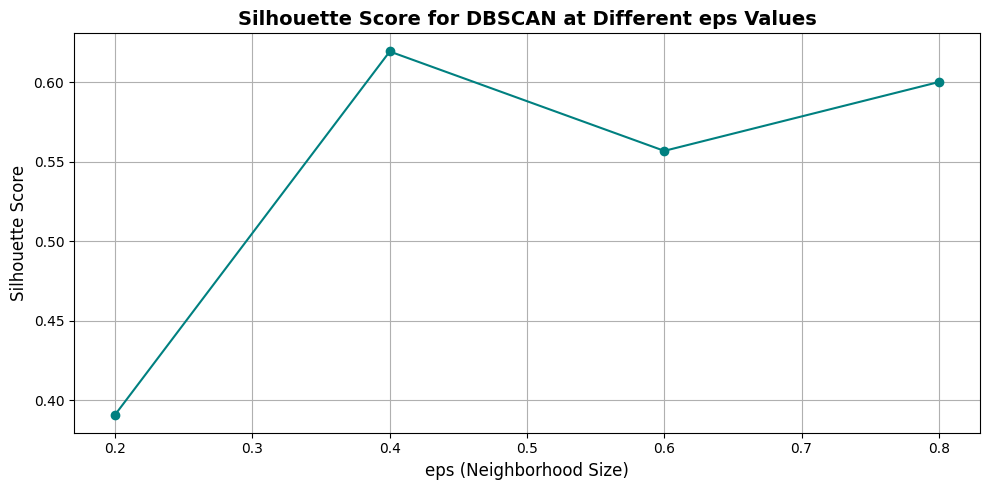

In [20]:
# Try multiple eps values
eps_values = np.arange(0.2, 3.0, 0.2)
sil_scores = []
n_clusters_list = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=5)
    labels = db.fit_predict(scaled_features)

    # DBSCAN can assign -1 for noise; filter if too many noise points
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    if n_clusters >= 2:  # valid clustering
        sil = silhouette_score(scaled_features, labels)
    else:
        sil = np.nan  # invalid silhouette score

    sil_scores.append(sil)
    n_clusters_list.append(n_clusters)

# Plot Silhouette Score vs Eps
plt.figure(figsize=(10, 5))
plt.plot(eps_values, sil_scores, marker='o', color='teal')
plt.xlabel('eps (Neighborhood Size)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for DBSCAN at Different eps Values', fontsize=14, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

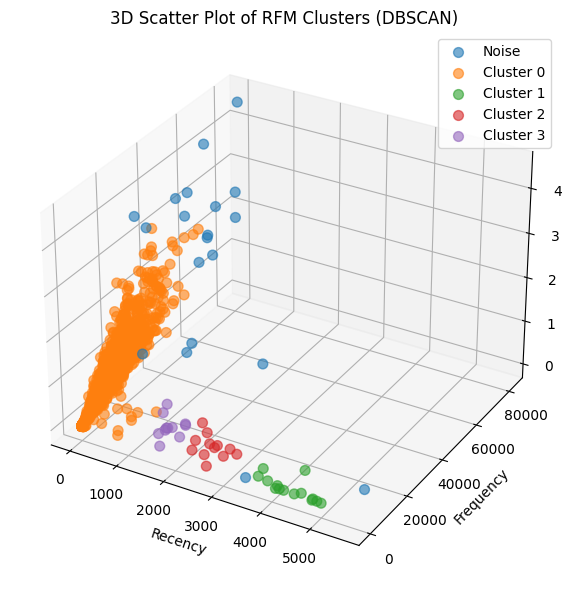

In [21]:
# Fit DBSCAN with chosen eps
dbscan = DBSCAN(eps=0.8, min_samples=5)
rfm_df['dbscan_cluster'] = dbscan.fit_predict(scaled_features)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in sorted(rfm_df['dbscan_cluster'].unique()):
    cluster_data = rfm_df[rfm_df['dbscan_cluster'] == cluster_id]
    label = 'Noise' if cluster_id == -1 else f'Cluster {cluster_id}'
    ax.scatter(
        cluster_data['recency'],
        cluster_data['frequency'],
        cluster_data['monetary'],
        label=label,
        s=50,
        alpha=0.6
    )

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters (DBSCAN)')
ax.legend()
plt.tight_layout()
plt.show()

### Agglomerative Model

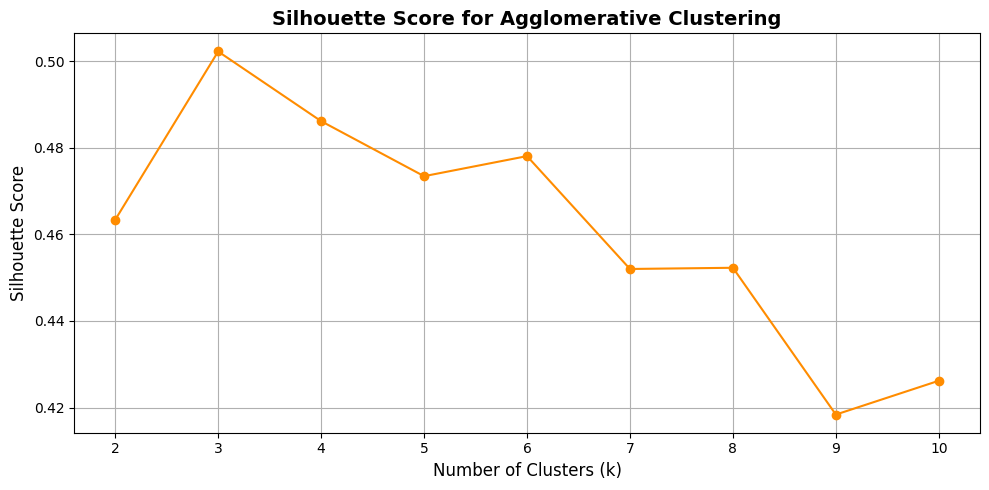

In [22]:
# Define K range
K_range = range(2, 11)

# Store metrics
sil_scores = []

# Agglomerative does not use inertia, but we can still use silhouette
for k in K_range:
    agg = AgglomerativeClustering(n_clusters=k)
    labels = agg.fit_predict(scaled_features)
    
    # Silhouette score only
    sil_scores.append(silhouette_score(scaled_features, labels))

# Plot Silhouette Score vs K
plt.figure(figsize=(10, 5))
plt.plot(K_range, sil_scores, marker='o', color='darkorange', label='Silhouette Score')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Silhouette Score for Agglomerative Clustering', fontsize=14, weight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()


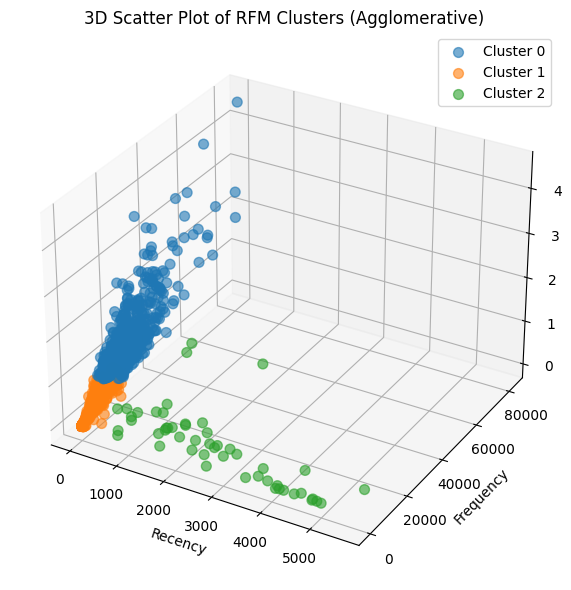

In [23]:
# Fit Agglomerative Clustering with 3 clusters
agg = AgglomerativeClustering(n_clusters=3)
rfm_df['agg_cluster'] = agg.fit_predict(scaled_features)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in sorted(rfm_df['agg_cluster'].unique()):
    cluster_data = rfm_df[rfm_df['agg_cluster'] == cluster_id]
    ax.scatter(
        cluster_data['recency'],
        cluster_data['frequency'],
        cluster_data['monetary'],
        label=f'Cluster {cluster_id}',
        s=50,
        alpha=0.6
    )

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters (Agglomerative)')
ax.legend()
plt.tight_layout()
plt.show()


### Gaussian Mixture Model

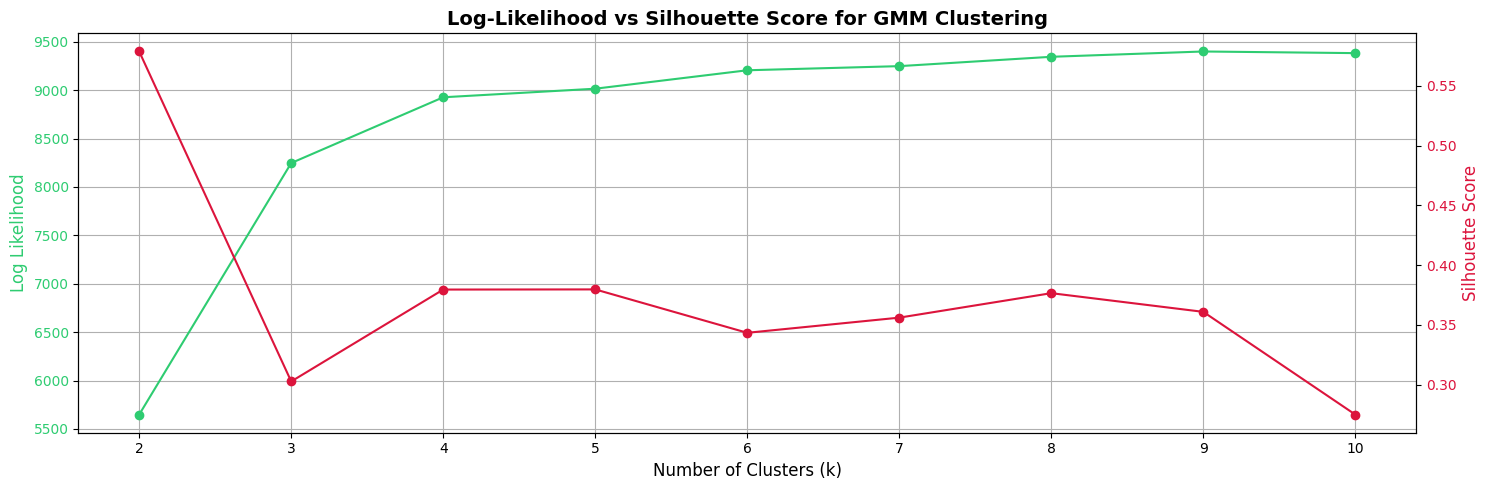

In [24]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import time

# Define K range
K_range = range(2, 11)

# Store metrics
log_likelihoods = []
sil_scores = []

# GMM Model Evaluation
for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    gmm.fit(scaled_features)
    
    # Predict labels
    gmm_labels = gmm.predict(scaled_features)
    
    # Append metrics
    log_likelihoods.append(gmm.score(scaled_features) * len(scaled_features))  # Total log-likelihood
    sil_scores.append(silhouette_score(scaled_features, gmm_labels))

# Plot Log-Likelihood vs Silhouette Score
fig, ax1 = plt.subplots(figsize=(15, 5))

# Log Likelihood Plot
ax1.plot(K_range, log_likelihoods, marker='o', color="#2ECC71", label='Log Likelihood')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Log Likelihood', color="#2ECC71", fontsize=12)
ax1.tick_params(axis='y', labelcolor="#2ECC71")

# Silhouette Score on second y-axis
ax2 = ax1.twinx()
ax2.plot(K_range, sil_scores, marker='o', color='crimson', label='Silhouette Score')
ax2.set_ylabel('Silhouette Score', color='crimson', fontsize=12)
ax2.tick_params(axis='y', labelcolor='crimson')

plt.title('Log-Likelihood vs Silhouette Score for GMM Clustering', fontsize=14, weight='bold')
ax1.grid(True)
plt.tight_layout()
plt.show()

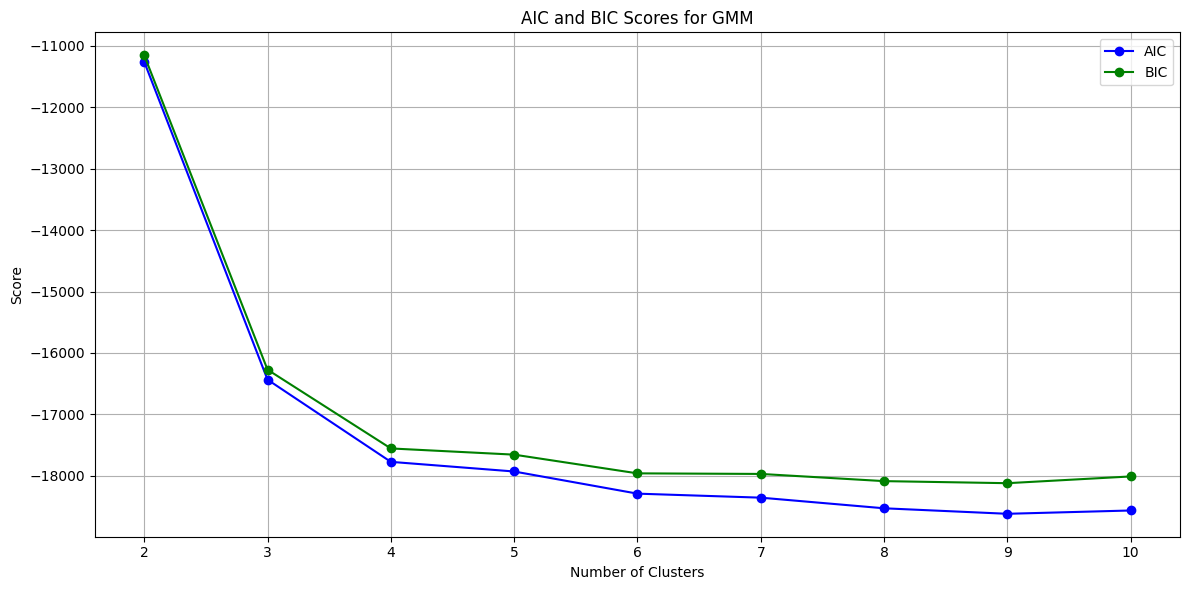

In [25]:
aics = []
bics = []

K_range = range(2, 11)

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5)
    gmm.fit(scaled_features)
    
    aics.append(gmm.aic(scaled_features))
    bics.append(gmm.bic(scaled_features))

# Plot AIC & BIC
plt.figure(figsize=(12, 6))
plt.plot(K_range, aics, label='AIC', marker='o', color='blue')
plt.plot(K_range, bics, label='BIC', marker='o', color='green')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('AIC and BIC Scores for GMM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



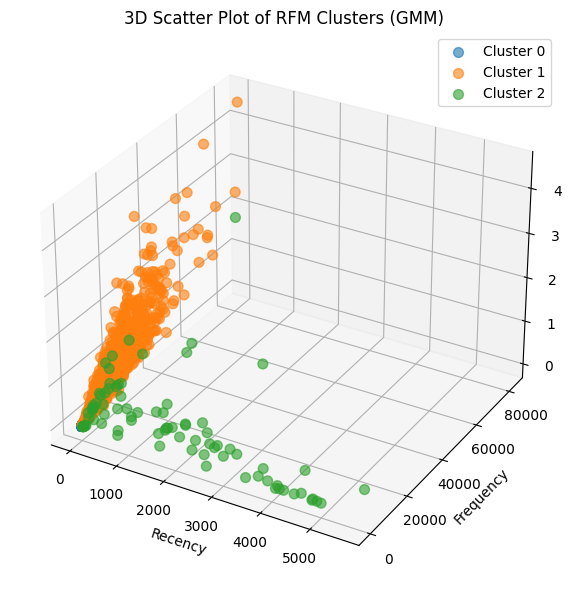

In [26]:
# Fit GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=42, n_init=5)
gmm.fit(scaled_features)

# Predict cluster labels
rfm_df['gmm_cluster'] = gmm.predict(scaled_features)

# 3D Scatter Plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

for cluster_id in sorted(rfm_df['gmm_cluster'].unique()):
    cluster_data = rfm_df[rfm_df['gmm_cluster'] == cluster_id]
    ax.scatter(
        cluster_data['recency'],
        cluster_data['frequency'],
        cluster_data['monetary'],
        label=f'Cluster {cluster_id}',
        s=50,
        alpha=0.6
    )

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Scatter Plot of RFM Clusters (GMM)')
ax.legend()
plt.tight_layout()
plt.show()

### Agglomerative (Best Model) Clusters Analysis

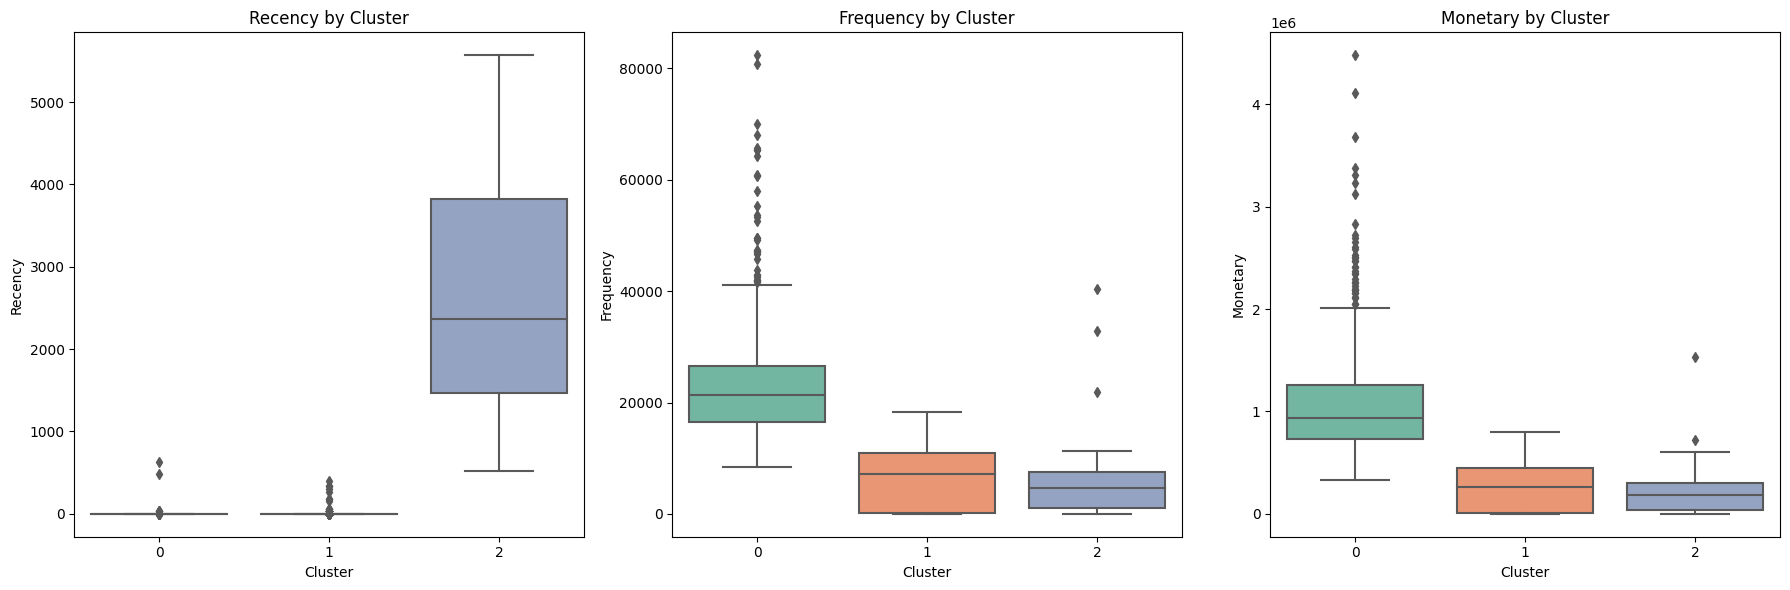

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the layout
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Recency
sns.boxplot(data=rfm_df, x='agg_cluster', y='recency', ax=axes[0], palette='Set2')
axes[0].set_title("Recency by Cluster")
axes[0].set_xlabel("Cluster")
axes[0].set_ylabel("Recency")

# Frequency
sns.boxplot(data=rfm_df, x='agg_cluster', y='frequency', ax=axes[1], palette='Set2')
axes[1].set_title("Frequency by Cluster")
axes[1].set_xlabel("Cluster")
axes[1].set_ylabel("Frequency")

# Monetary
sns.boxplot(data=rfm_df, x='agg_cluster', y='monetary', ax=axes[2], palette='Set2')
axes[2].set_title("Monetary by Cluster")
axes[2].set_xlabel("Cluster")
axes[2].set_ylabel("Monetary")

plt.tight_layout()
plt.show()

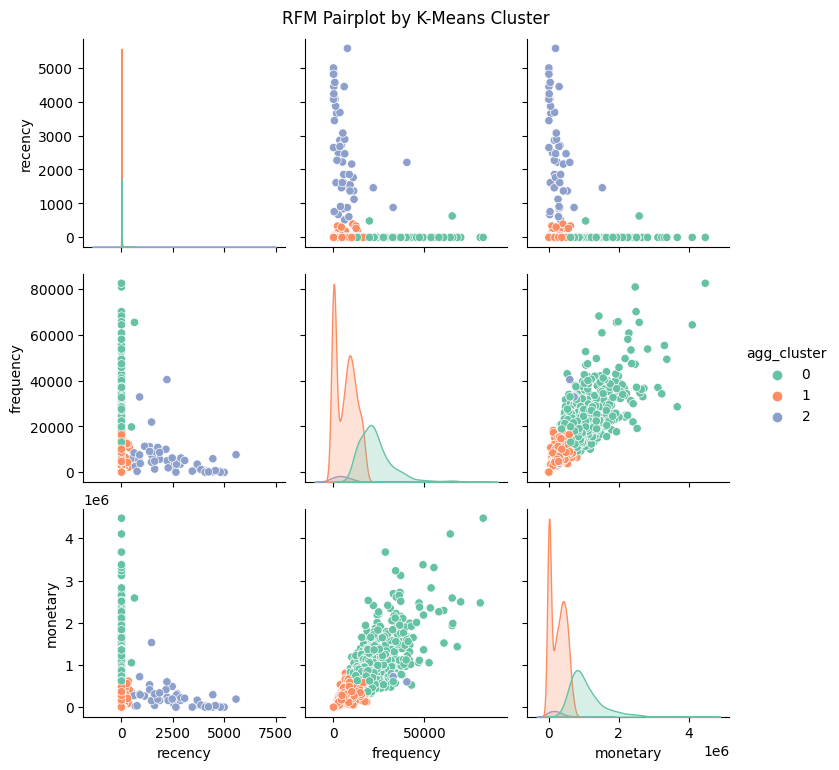

In [28]:
# Inspect pairwise feature distribution
sns.pairplot(rfm_df, vars=["recency", "frequency", "monetary"], hue="agg_cluster", palette="Set2")
plt.suptitle("RFM Pairplot by K-Means Cluster", y=1.02)
plt.show()

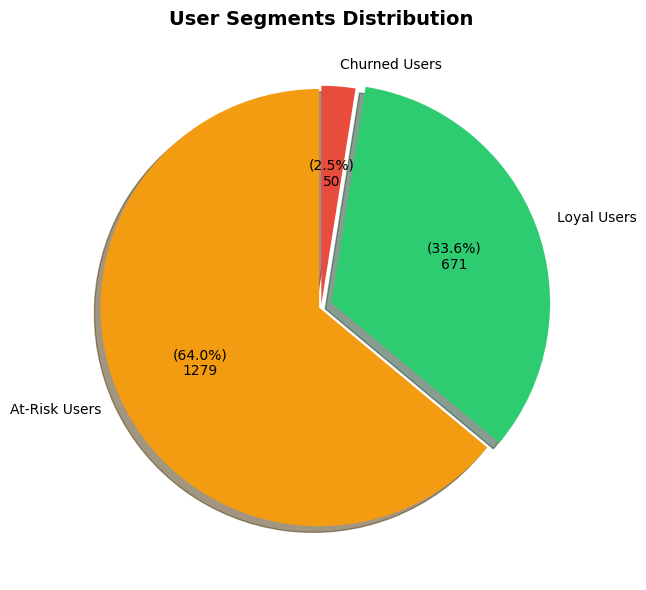

In [29]:
# Map cluster labels to descriptive names
label_map = {
    0: 'Loyal Users',
    1: 'At-Risk Users',
    2: 'Churned Users',
}

# Apply mapping to create a new column
rfm_df['agg_cluster'] = rfm_df['agg_cluster'].map(label_map)

# Define semantic colors for each segment
segment_color_map = {
    'Loyal Users': '#2ECC71',       # Green
    'At-Risk Users': '#F39C12',     # Orange
    'Churned Users': '#E74C3C'      # Red
}

# Step 3: Prepare data for pie chart
segment_counts = rfm_df['agg_cluster'].value_counts()
segment_labels = segment_counts.index.tolist()
segment_sizes = segment_counts.values.tolist()
colors = [segment_color_map[label] for label in segment_labels]
explode = [0.01, 0.05, 0.01]

# Step 4: Define autopct formatter
def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'({pct:.1f}%)\n{val}'
    return my_autopct

# Step 5: Plot the pie chart
fig = plt.figure(figsize=(7, 6))
gs = gridspec.GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0])

ax1.pie(
    segment_sizes,
    labels=segment_labels,
    autopct=make_autopct(segment_sizes),
    colors=colors,
    explode=explode,
    startangle=90,
    shadow=True,
    textprops={'fontsize': 10}
)

ax1.set_title("User Segments Distribution", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [30]:
rfm_df.head()

,user_id,last_trans_date,frequency,monetary,recency,frequency_score,monetary_score,recency_score,rule_based_cluster,k_means_cluster,dbscan_cluster,agg_cluster,gmm_cluster
0,31,2020-02-28 23:32:00,14088,611191.18,0,4,4,5,Champions,0,0,Loyal Users,1
1,85,2020-02-28 22:15:00,177,23059.70,0,1,2,5,New Low Spenders,0,0,At-Risk Users,1
2,65,2020-02-28 06:10:00,10304,701828.56,0,3,4,5,Recent Big Spenders,0,0,At-Risk Users,1
3,53,2020-02-28 16:19:00,20517,909438.29,0,5,5,5,Champions,1,0,Loyal Users,1
4,78,2020-02-28 20:20:00,11152,473608.53,0,3,3,5,Recent Medium Spenders,0,0,At-Risk Users,1


## Geographic User Segmentation

In [31]:
# Group users by state
count_per_state_df = data.groupBy("user_state").count() \
.withColumnRenamed("count", "user_count").orderBy("user_count", ascending=False).toPandas()

# Group users by city
count_per_city_df = data.groupBy("user_city").count() \
.withColumnRenamed("count", "user_count").orderBy("user_count", ascending=False).toPandas()

# Group users by state
location_counts_df = data.groupBy("user_state", "user_city", "user_latitude", "user_longitude") \
                           .count() \
                           .withColumnRenamed("count", "user_count") \
                           .toPandas()

count_per_state_df['user_state'] = count_per_state_df['user_state'].apply(lambda x: x.upper())
count_per_city_df['user_city'] = count_per_city_df['user_city'].apply(lambda x: x.capitalize())

# Check data consistency in the city and state columns
print("Number of duplicated rows in the state column = ", count_per_state_df.duplicated().sum())
print("Number of duplicated rows in the city column = ", count_per_city_df.duplicated().sum())

Number of duplicated rows in the state column =  0
Number of duplicated rows in the city column =  0


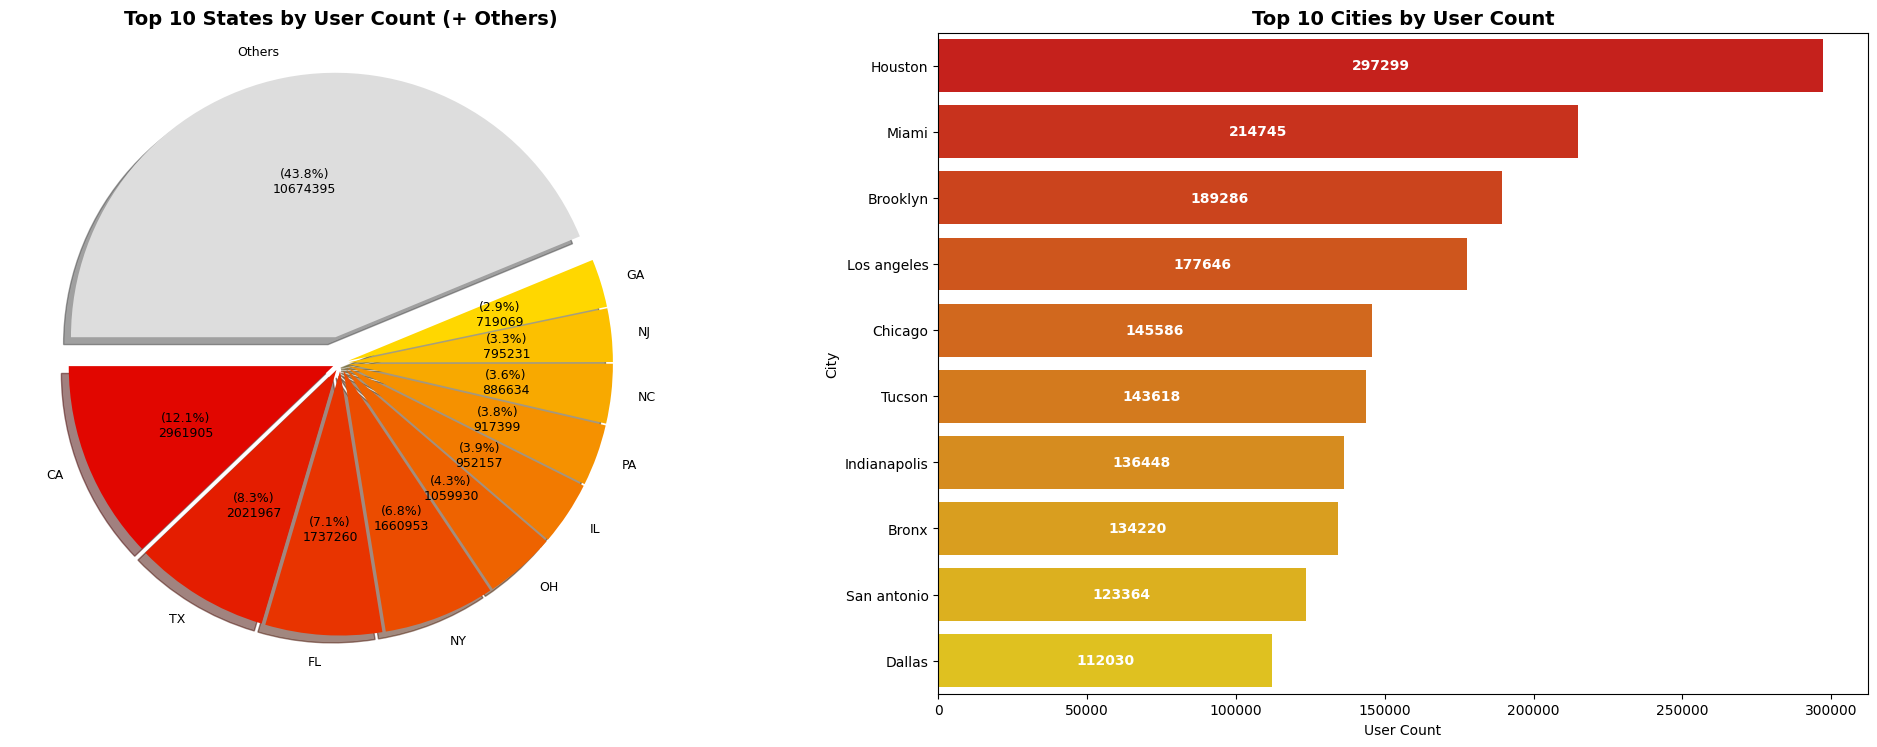

In [33]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import plotly.express as px
from matplotlib.gridspec import GridSpec
from IPython.display import display
import plotly.io as pio

# --- PIE AND BAR PLOTS IN FIRST ROW ---

fig = plt.figure(constrained_layout=True, figsize=(20, 14))
gs = GridSpec(2, 2, figure=fig)

# PIE CHART (Top-left)
ax1 = fig.add_subplot(gs[0, 0])

others_color = '#DDDDDD'
num_slices = 11
cmap = mcolors.LinearSegmentedColormap.from_list("red_yellow", [YALLA_RED, YALLA_YELLOW])
gradient_colors = [cmap(i / (num_slices - 2)) for i in range(num_slices - 1)]
colors = gradient_colors + [others_color]

state_data = count_per_state_df.sort_values(by="user_count", ascending=False)
top_10_states = state_data.head(10)
others_state_count = state_data["user_count"].iloc[10:].sum()

state_labels = list(top_10_states["user_state"]) + ["Others"]
state_sizes = list(top_10_states["user_count"]) + [others_state_count]

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct * total / 100.0))
        return f'({pct:.1f}%)\n{val}'
    return my_autopct

explode = [0.03]*10 + [0.1]

ax1.pie(
    state_sizes,
    labels=state_labels,
    autopct=make_autopct(state_sizes),
    colors=colors,
    explode=explode,
    startangle=180,
    shadow=True,
    textprops={'fontsize': 9}
)
ax1.set_title("Top 10 States by User Count (+ Others)", fontsize=14, weight='bold')

# BAR PLOT (Top-right)
ax2 = fig.add_subplot(gs[0, 1])

num_bars = 10
cmap = mcolors.LinearSegmentedColormap.from_list("red_yellow", [YALLA_RED, YALLA_YELLOW])
gradient_colors = [cmap(i / (num_bars - 1)) for i in range(num_bars)]

city_data = count_per_city_df.sort_values(by="user_count", ascending=False)
top_10_cities = city_data.head(10)

sns.barplot(
    data=top_10_cities,
    y="user_city",
    x="user_count",
    palette=gradient_colors,
    ax=ax2
)
ax2.set_title("Top 10 Cities by User Count", fontsize=14, weight='bold')
ax2.set_xlabel("User Count")
ax2.set_ylabel("City")

for i, val in enumerate(top_10_cities["user_count"]):
    ax2.text(
        val / 2,
        i,
        str(val),
        ha='center', va='center',
        color='white', fontsize=10, weight='bold'
    )

plt.show()

# --- INTERACTIVE MAP IN SECOND ROW ---
fig_map = px.scatter_mapbox(
    location_counts_df,
    lat="user_latitude",
    lon="user_longitude",
    size="user_count",
    color="user_count",
    hover_name="user_city",
    hover_data=["user_state", "user_count"],
    color_continuous_scale="YlOrRd",
    size_max=30,
    zoom=3,
    height=600
)

fig_map.update_layout(mapbox_style="open-street-map")
fig_map.update_layout(
    title="Interactive User Distribution by Location",
    margin={"r":0,"t":40,"l":0,"b":0}
)

fig_map.show()